# 6. "Ogród zoologiczny" wzorów

W poprzednim etapie przeprowadziliśmy analizę liniowej stabilności, która wykazała, że dla pewnych zestawów parametrów jednorodny stan równowagi staje się niestabilny. Zgodnie z teorią Turinga, powinno to prowadzić do spontanicznego wyłonienia się stacjonarnych struktur przestrzennych.

Rozwiążemy teraz układ równań reakcji-dyfuzji na dwuwymiarowej siatce, aby:
1.  **Zweryfikować wyniki analityczne:** Sprawdzić, czy przewidziana niestabilność faktycznie prowadzi do powstania wzorów.
2.  **Zbadać morfologię rozwiązań:** Zaobserwować, jak zmiana parametru opadów $A$ wpływa na kształt wzorów.

### Model Matematyczny (Klausmeier) w 2D
Rozwiązujemy pełny układ równań różniczkowych cząstkowych (PDE) z uwzględnieniem dyfuzji w obu kierunkach przestrzennych ($x, y$):

$$
\frac{\partial u}{\partial t} = d_1 \Delta u + A - u - u v^2
$$

$$
\frac{\partial v}{\partial t} = d_2 \Delta v - m v + u v^2
$$

Operator Laplace'a: $\Delta = \frac{\partial^2}{\partial x^2} + \frac{\partial^2}{\partial y^2}$.


Do symulacji wykorzystamy metodę różnic skończonych z jawnym schematem czasowym.
* **Warunki brzegowe:** stosujemy jednorodne warunki Dirichleta.
* **Warunki początkowe:** symulację rozpoczynamy od losowego rozrzucenia roślinności po całej planszy.

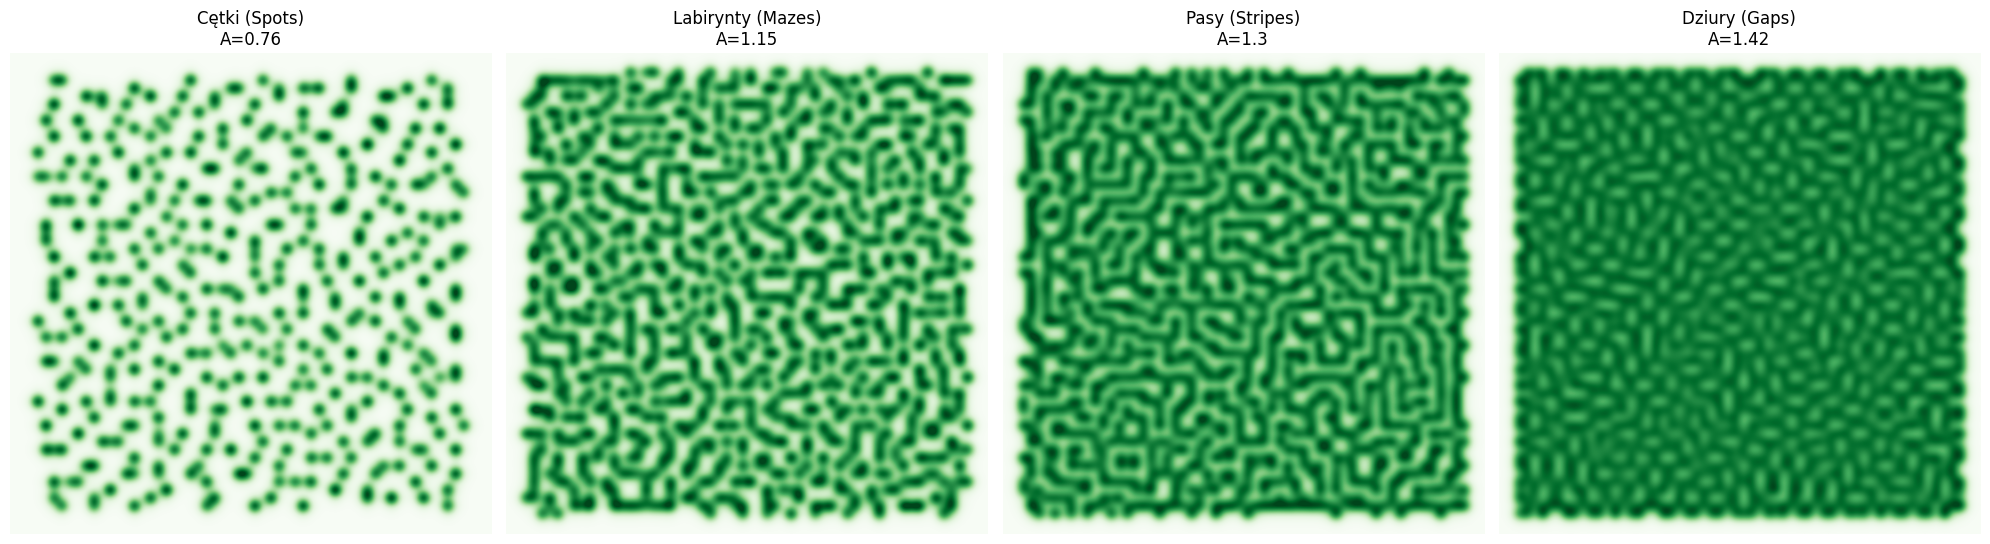

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def solve_klausmeier(N, h_x, h_t, T_max, A, M, u_init, v_init):
    # tablice
    u = u_init.copy()
    v = v_init.copy()
    
    # parametry dyfuzji (d1=1.0, d2=0.01)
    r_u = 1.0 * h_t / (h_x**2)
    r_v = 0.01 * h_t / (h_x**2)
    
    steps = int(T_max / h_t)
        
    for i in range(steps):
        # obliczamy środek obszaru
        u_mid = u[1:-1, 1:-1]
        v_mid = v[1:-1, 1:-1]
        
        # Laplasjany (dyfuzja) - schemat 5-punktowy
        Lu = (u[:-2, 1:-1] + u[2:, 1:-1] + u[1:-1, :-2] + u[1:-1, 2:] - 4*u_mid)
        Lv = (v[:-2, 1:-1] + v[2:, 1:-1] + v[1:-1, :-2] + v[1:-1, 2:] - 4*v_mid)
        
        # reakcja
        # u_t = A - u - u*v^2
        # v_t = u*v^2 - m*v
        uv2 = u_mid * (v_mid**2)
        
        du = A - u_mid - uv2
        dv = uv2 - M * v_mid
        
        # metoda Eulera
        u[1:-1, 1:-1] += r_u * Lu + h_t * du
        v[1:-1, 1:-1] += r_v * Lv + h_t * dv
        
        # wwarunki brzegowe (Dirichlet)
        u[0,:]=0; u[-1,:]=0
        u[:,0]=0; u[:,-1]=0
        v[0,:]=0; v[-1,:]=0
        v[:,0]=0; v[:,-1]=0
        
        # zabezpieczenie przed wybuchem
        if i % 200 == 0:
            u = np.clip(u, 0, 100)
            v = np.clip(v, 0, 100)
            
    return v # rośliny

N_points = 60
h_x = 0.5       
h_t = 0.005     
T_max = 300     
M = 0.45

x_grid = np.arange(0, N_points * h_x, h_x) 
X, Y = np.meshgrid(x_grid, x_grid)

scenarios = [
    {"name": "Cętki (Spots)",      "A": 0.76}, 
    {"name": "Labirynty (Mazes)",  "A": 1.15}, 
    {"name": "Pasy (Stripes)",     "A": 1.3}, 
    {"name": "Dziury (Gaps)",      "A": 1.42}
]

fig, axes = plt.subplots(1, 4, figsize=(20, 6))

for i, scen in enumerate(scenarios):
    A = scen["A"]
    name = scen["name"]
    
    if name == "Cętki (Spots)":
        v_start = np.random.random((N_points, N_points)) * 2.0
    elif name == "Labirynty (Mazes)":
        v_start = np.random.random((N_points, N_points)) * 2.0
    elif name == "Pasy (Stripes)":
        v_start = np.ones((N_points, N_points)) * 1.0 + (np.random.random((N_points, N_points)) - 0.5) * 1.0
    elif name == "Dziury (Gaps)":
        v_start = np.ones((N_points, N_points)) * 1.5 + (np.random.random((N_points, N_points)) - 0.5) * 0.5
        
    u_start = np.ones((N_points, N_points)) * A
    final_v = solve_klausmeier(N_points, h_x, h_t, T_max, A, M, u_start, v_start)
    
    axes[i].imshow(final_v, cmap='Greens', interpolation='bicubic', origin='lower', vmin=0, vmax=3.5)
    axes[i].set_title(f"{name}\nA={A}")
    axes[i].axis('off')

plt.tight_layout()
plt.savefig("../wzory.png", dpi=300, bbox_inches='tight')
plt.show()

### Wpływ dostępności wody na wzory
Zgodnie z przewidywaniami teoretycznymi, wzrost parametru $A$ prowadzi do ciągłych przejść fazowych między różnymi typami struktur:

* **cętki (spots) – $A=0.76$:**
    przy niskich opadach biomasa skupia się w izolowanych kępach. Rośliny rosną w grupach, aby lokalnie zwiększyć wilgotność gleby, podczas gdy otaczający teren pozostaje pustynny.
* **labirynty (mazes) – $A=1.15$:**
    wraz ze wzrostem zasobów, kępy zaczynają się łączyć, tworząc nieregularne, wijące się struktury. System optymalizuje dostęp do wody poprzez wydłużanie stref wegetacji.
* **pasy (stripes) – $A=1.30$:**
    dalsze zwiększanie parametru $A$ prowadzi do pogrubienia struktur i formowania się wyraźnych pasów. Jest to stan przejściowy, w którym konkurencja o wodę jest zbalansowana.
* **dziury (gaps) – $A=1.42$:**
    przy wysokich opadach system dąży do pełnego zalesienia. Konkurencja między roślinami objawia się jedynie występowaniem lokalnych dziur w zwartej pokrywie roślinnej.

### Wpływ warunków brzegowych
Na wszystkich wygenerowanych mapach biomasy widoczna jest charakterystyczna pusta ramka otaczająca obszar symulacji. Jest to efekt zastosowania **warunków brzegowych Dirichleta** ($u=v=0$ na krawędziach). Poza badanym obszarem panują skrajnie niekorzystne warunki (pustynia), które pochłaniają zasoby i uniemożliwiają rozwój biomasy na styku z otoczeniem.

### Wnioski końcowe
Niewielka zmiana parametru opadów może drastycznie zmienić strukturę krajobrazu – od zwartego lasu (dziury), przez pasy, aż do skrajnie fragmentowanych cętek.

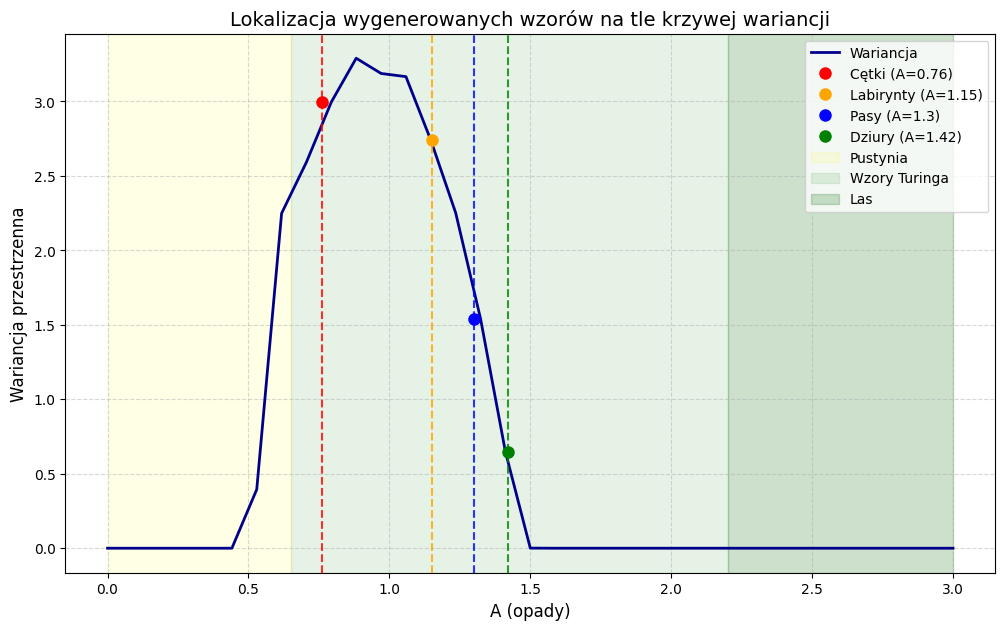

In [2]:
import numpy as np
import matplotlib.pyplot as plt

def get_variance_integrated(A_val):
    N = 30           
    h_x = 0.5        
    h_t = 0.005      
    T = 200          
    M = 0.45
    
    u = np.ones((N, N)) * A_val
    
    if A_val < 1.25:
        v = np.random.random((N, N)) * 2.0
    else:
        v = np.ones((N, N)) * 1.5 + (np.random.random((N, N)) - 0.5) * 1.0

    steps = int(T / h_t)
    r_u = 1.0 * h_t / (h_x**2)
    r_v = 0.01 * h_t / (h_x**2)
    
    for i in range(steps):
        u_mid = u[1:-1, 1:-1]; v_mid = v[1:-1, 1:-1]
        
        Lu = (u[:-2, 1:-1] + u[2:, 1:-1] + u[1:-1, :-2] + u[1:-1, 2:] - 4*u_mid)
        Lv = (v[:-2, 1:-1] + v[2:, 1:-1] + v[1:-1, :-2] + v[1:-1, 2:] - 4*v_mid)
        
        uv2 = u_mid * (v_mid**2)
        
        u[1:-1, 1:-1] += r_u * Lu + h_t * (A_val - u_mid - uv2)
        v[1:-1, 1:-1] += r_v * Lv + h_t * (uv2 - M * v_mid)
        
        # Dirichlet
        u[0,:]=0; u[-1,:]=0; u[:,0]=0; u[:,-1]=0
        v[0,:]=0; v[-1,:]=0; v[:,0]=0; v[:,-1]=0
        
        if i % 100 == 0:
            u = np.clip(u, 0, 50); v = np.clip(v, 0, 50)
            
    # środek do statystyki (bez pustej ramki)
    v_center = v[5:-5, 5:-5]
    return np.var(v_center)

A_values = np.linspace(0.0, 3.0, 35)
variances = []

for i, val in enumerate(A_values):
    try:
        var = get_variance_integrated(val)
        variances.append(var)
    except:
        variances.append(0)

plt.figure(figsize=(12, 7))

plt.plot(A_values, variances, '-', color='darkblue', linewidth=2, label='Wariancja')

my_points = [0.76, 1.15, 1.30, 1.42]
labels = ['Cętki', 'Labirynty', 'Pasy', 'Dziury']
colors = ['red', 'orange', 'blue', 'green']

for pt, lab, col in zip(my_points, labels, colors):
    plt.axvline(x=pt, color=col, linestyle='--', alpha=0.8)
    idx = (np.abs(A_values - pt)).argmin()
    plt.plot(pt, variances[idx], 'o', color=col, markersize=8, label=f'{lab} (A={pt})')

# tło
plt.axvspan(0.0, 0.65, color='yellow', alpha=0.1, label='Pustynia')
plt.axvspan(0.65, 2.2, color='green', alpha=0.1, label='Wzory Turinga')
plt.axvspan(2.2, 3.0, color='darkgreen', alpha=0.2, label='Las')

plt.title("Lokalizacja wygenerowanych wzorów na tle krzywej wariancji", fontsize=14)
plt.xlabel("A (opady)", fontsize=12)
plt.ylabel("Wariancja przestrzenna", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()

plt.savefig("../wykres_wariancji.png", dpi=300, bbox_inches='tight')
plt.show()